In [90]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

     


In [62]:
# Load the dataset
file_path = 'C:/Users/dugga/OneDrive/Desktop/ML1/ML/data/AAPL.csv'
data = pd.read_csv(file_path)

# Select the 'Close' column and additional features
features = ['Close', 'Open', 'High', 'Low', 'Volume']
selected_data = data[features].values

# Normalize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(selected_data)

# Create sequences
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])  # 0 index for 'Close' price
    return np.array(X), np.array(y)

# Define the sequence length
seq_length = 60

# Create sequences
X, y = create_sequences(scaled_data, seq_length)

# Split the data into training and testing sets
split_ratio = 0.8
split_index = int(len(X) * split_ratio)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Reshape data for MLP
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)


In [6]:
# Define the MLP model
model = Sequential([
    Dense(256, input_dim=X_train_reshaped.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])

C:\Users\dugga\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model
history = model.fit(
    X_train_reshaped, y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0542 - val_loss: 0.0281 - learning_rate: 0.0010
Epoch 2/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0067 - val_loss: 0.0384 - learning_rate: 0.0010
Epoch 3/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0038 - val_loss: 0.0520 - learning_rate: 0.0010
Epoch 4/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0024 - val_loss: 0.0740 - learning_rate: 0.0010
Epoch 5/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0015 - val_loss: 0.0952 - learning_rate: 0.0010
Epoch 6/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.8142e-04 - val_loss: 0.1212 - learning_rate: 0.0010
Epoch 7/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.1940e-04 - val_loss: 0.1248 - learning_rate: 2.0000e-04
Epoch 8/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.3167e-04 - val_loss: 0.1287 - learning_rate: 2.0000e-04
Epoch 9/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.7277e-04 - val_loss: 0.1318 

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9475
Test Loss: 4.488927841186523
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
RMSE: 63.964349606646465
MAE: 47.602982899258286
MAPE: 70.73314980397166


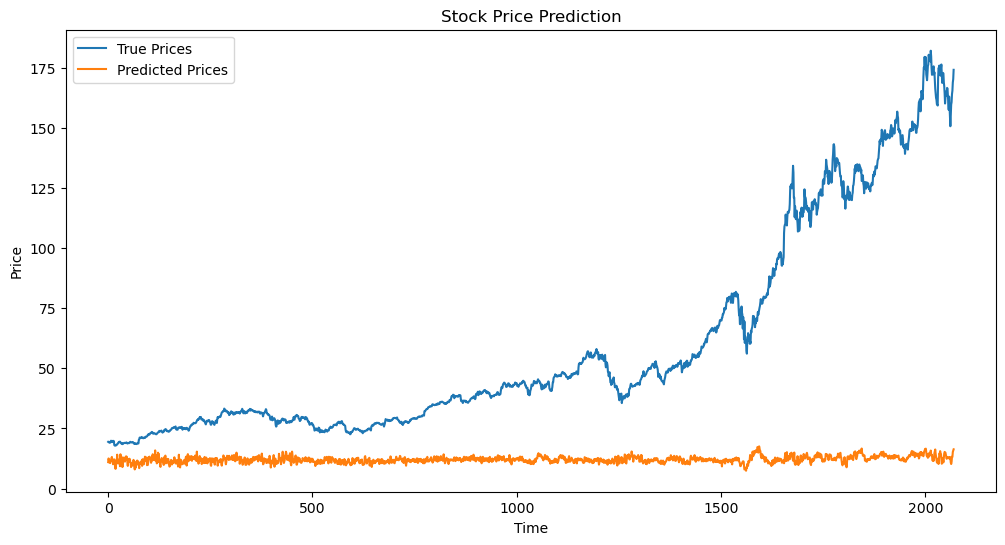

In [10]:
# Evaluate the model on the test set
loss = model.evaluate(X_test_reshaped, y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test_reshaped)

# Inverse transform the predictions and true values to get the original scale
predictions_temp = np.zeros((len(predictions), 5))
predictions_temp[:, 0] = predictions.flatten()
predictions_inverse = scaler.inverse_transform(predictions_temp)[:, 0]

y_test_temp = np.zeros((len(y_test), 5))
y_test_temp[:, 0] = y_test
y_test_inverse = scaler.inverse_transform(y_test_temp)[:, 0]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_inverse, predictions_inverse))
print(f'RMSE: {rmse}')

# Calculate MAE
mae = mean_absolute_error(y_test_inverse, predictions_inverse)
print(f'MAE: {mae}')

# Calculate MAPE
mape = np.mean(np.abs((y_test_inverse - predictions_inverse) / y_test_inverse)) * 100
print(f'MAPE: {mape}')

# Plot the predictions against the true values
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='True Prices')
plt.plot(predictions_inverse, label='Predicted Prices')
plt.legend()
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

# Plot the t

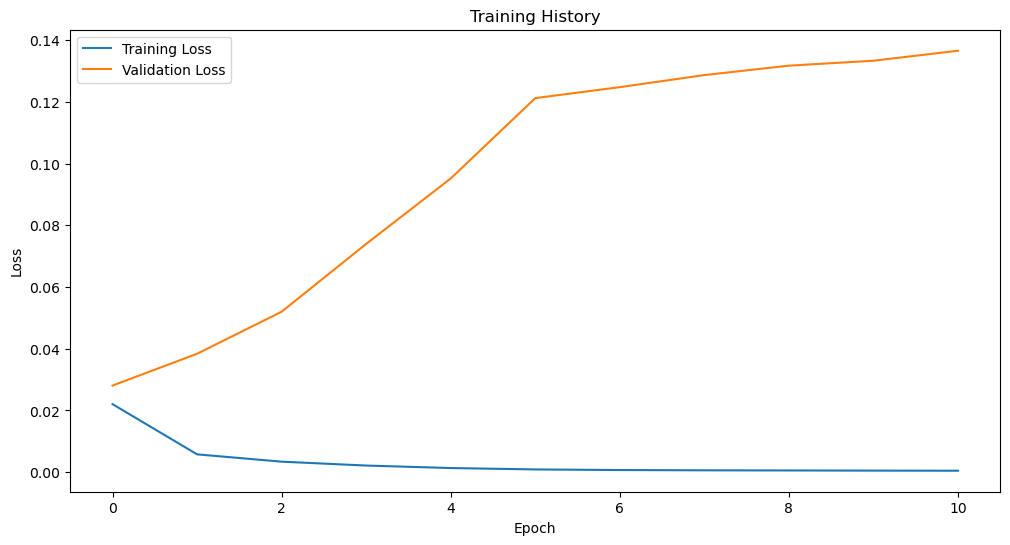

In [12]:
# Plot the training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [110]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np

# Load the dataset
file_path = 'C:/Users/dugga/OneDrive/Desktop/ML1/ML/data/AAPL.csv'
data = pd.read_csv(file_path)

# Select the 'Close' column and additional features
features = ['Close', 'Open', 'High', 'Low', 'Volume']
selected_data = data[features].values

# Normalize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(selected_data)

# Create sequences
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])  # 0 index for 'Close' price
    return np.array(X), np.array(y)

# Define the sequence length
seq_length = 60

# Create sequences
X, y = create_sequences(scaled_data, seq_length)

tscv= TimeSeriesSplit(n_splits=5)
rmse_scores = []
mae_scores = []
mape_scores = []


for train_index, val_index in tscv.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Reshape data for MLP
    X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
    X_test_reshaped = X_val.reshape(X_val.shape[0], -1)
    # Define the MLP model
    model = Sequential([
    Dense(256, input_dim=X_train_reshaped.shape[1], activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
    ])

    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

    # Train the model
    history = model.fit(
    X_train_reshaped, y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr]
    )



    # Evaluate the model on the test set
    loss = model.evaluate(X_test_reshaped, y_val)
    print(f'Test Loss: {loss}')

    # Make predictions
    predictions = model.predict(X_test_reshaped)
    
    epsilon = 1e-5  # Small threshold to avoid division by zero
    y_val_adjusted = np.maximum(y_val, epsilon)
    y_pred_adjusted = np.maximum(predictions, epsilon)
    
    # Inverse transform the predictions and true values to get the original scale
    predictions_temp = np.zeros((len(predictions), 5))
    predictions_temp[:, 0] = predictions.flatten()
    predictions_inverse = scaler.inverse_transform(predictions_temp)[:, 0]

    y_test_temp = np.zeros((len(y_val), 5))
    y_test_temp[:, 0] = y_val
    y_test_inverse = scaler.inverse_transform(y_test_temp)[:, 0]

    # Inverse transform the adjusted predictions and adjusted true values to get the original scale
    predictions_temp = np.zeros((len(y_pred_adjusted), 5))
    predictions_temp[:, 0] = y_pred_adjusted.flatten()
    predictions_inverse_ad = scaler.inverse_transform(predictions_temp)[:, 0]

    y_test_temp = np.zeros((len(y_val_adjusted ), 5))
    y_test_temp[:, 0] = y_val_adjusted 
    y_test_inverse_ad = scaler.inverse_transform(y_test_temp)[:, 0]


    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test_inverse, predictions_inverse))

    # Calculate MAE
    mae = mean_absolute_error(y_test_inverse, predictions_inverse)

    # Calculate MAPE
   
    mape = np.mean(np.abs((y_test_inverse_ad - predictions_inverse_ad) / y_test_inverse_ad)) * 100

    rmse_scores.append(rmse)
    mae_scores.append(mae)
    mape_scores.append(mape)

    # Calculate average scores
    avg_rmse = np.mean(rmse_scores)
    avg_mae = np.mean(mae_scores)
    avg_mape = np.mean(mape_scores)

Epoch 1/100


C:\Users\dugga\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1732 - val_loss: 0.0029 - learning_rate: 0.0010
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0123 - val_loss: 0.0025 - learning_rate: 0.0010
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0074 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 9.8904e-04 - learning_rate: 0.0010
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 8.7433e-04 - learning_rate: 0.0010
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - val_loss: 6.6017e-04 - learning_rate: 0.0010
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0026 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021 - val_loss: 7.7792e-04 - learning_rate: 0.0010
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019 - val_loss: 0.0011 - learning_rate: 0.0010
Epoch 10/100
2

C:\Users\dugga\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2015 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0105 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0059 - val_loss: 9.0272e-04 - learning_rate: 0.0010
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0037 - val_loss: 0.0011 - learning_rate: 0.0010
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027 - val_loss: 9.0127e-04 - learning_rate: 0.0010
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020 - val_loss: 7.6864e-04 - learning_rate: 0.0010
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019 - val_loss: 8.7931e-04 - learning_rate: 0.0010
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015 - val_loss: 4.9930e-04 - learning_rate: 0.0010
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 - val_loss: 9.8559e-04 - learning_rate: 0.0010
Epoch 1

C:\Users\dugga\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0538 - val_loss: 0.0119 - learning_rate: 0.0010
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032 - val_loss: 0.0097 - learning_rate: 0.0010
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020 - val_loss: 0.0084 - learning_rate: 0.0010
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 - val_loss: 0.0073 - learning_rate: 0.0010
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 - val_loss: 0.0066 - learning_rate: 0.0010
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0010 - val_loss: 0.0058 - learning_rate: 0.0010
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.8455e-04 - val_loss: 0.0053 - learning_rate: 0.0010
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.8931e-04 - val_loss: 0.0046 - learning_rate: 0.0010
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.9129e-04 - val_loss: 0.0047 - learning_rate: 0.0010
Epoch 10/100
65/65 

C:\Users\dugga\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0634 - val_loss: 0.0362 - learning_rate: 0.0010
Epoch 2/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0060 - val_loss: 0.0052 - learning_rate: 0.0010
Epoch 3/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036 - val_loss: 0.0022 - learning_rate: 0.0010
Epoch 4/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0023 - val_loss: 0.0022 - learning_rate: 0.0010
Epoch 5/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015 - val_loss: 0.0019 - learning_rate: 0.0010
Epoch 6/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 7/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.9271e-04 - val_loss: 0.0019 - learning_rate: 0.0010
Epoch 8/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.1021e-04 - val_loss: 0.0028 - learning_rate: 0.0010
Epoch 9/100
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.4816e-04 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 10/100
87/87 

C:\Users\dugga\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0404 - val_loss: 0.0215 - learning_rate: 0.0010
Epoch 2/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0038 - val_loss: 0.0172 - learning_rate: 0.0010
Epoch 3/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0019 - val_loss: 0.0230 - learning_rate: 0.0010
Epoch 4/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015 - val_loss: 0.0321 - learning_rate: 0.0010
Epoch 5/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013 - val_loss: 0.0491 - learning_rate: 0.0010
Epoch 6/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.8574e-04 - val_loss: 0.0513 - learning_rate: 0.0010
Epoch 7/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.9251e-04 - val_loss: 0.0795 - learning_rate: 0.0010
Epoch 8/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.7279e-04 - val_loss: 0.0807 - learning_rate: 2.0000e-04
Epoch 9/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.5151e-04 - val_loss: 0.0816 - learning_rate: 

In [112]:
print(f"Average RMSE: {avg_rmse}")
print(f"Average MAE: {avg_mae}")
print(f"Average MAPE: {avg_mape}")



Average RMSE: 10.990170445839365
Average MAE: 6.401003653936303
Average MAPE: 15.21711604500669


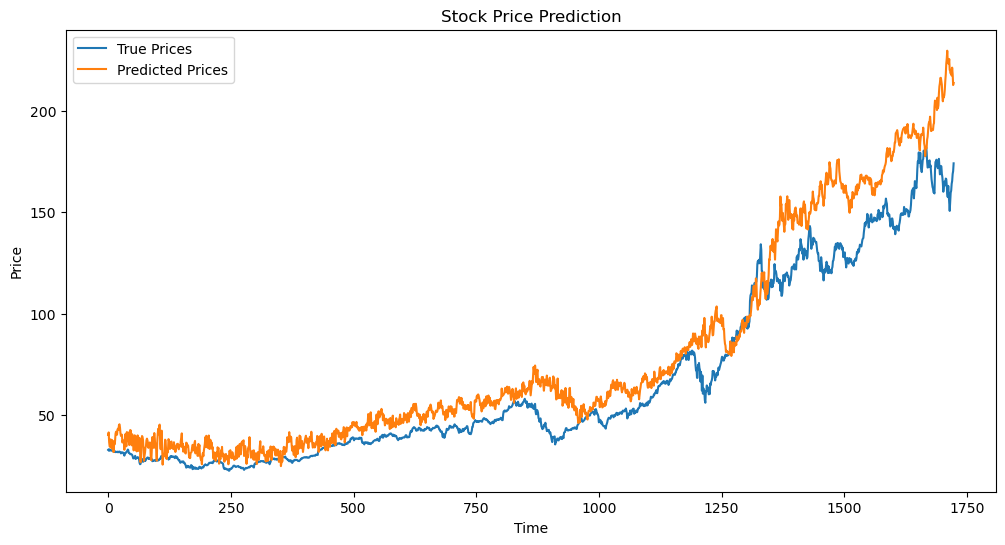

In [114]:
# Plot the predictions against the true values
y_test_inverse=np.array(y_test_inverse)
predictions_inverse=np.array(predictions_inverse)
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='True Prices')
plt.plot(predictions_inverse, label='Predicted Prices')
plt.legend()
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()